# 상품 간 연관성 분석
- 판매되는 상품 간 연관성에 대해 탐색합니다.
- '기저귀와 맥주는 함께 팔리는 경향이 있다'는 사실에 대한 호기심에서 시작된 분석입니다.
- 장바구니 분석(Market Basker Analysis)의 지표를 통해 수치적으로 확인할 수 있습니다.
- 'A 상품과 B 상품이 함께 팔릴 확률이 P더라'라는 분석 결과를 재해석하여 모델에 반영합니다.
    - '고객 맞춤 상품 추천'의 상황에 적합한 학습 데이터를 구성하고, 예측 결과값으로는 각 카테고리에 대한 probability값을 반환하도록 모델링하였습니다.(소프트맥스)

## import & load data

In [13]:
# import library
import math
import numpy as np 
import pandas as pd 
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
import itertools

# market basket analysis libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

# visualizaition
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import missingno as msno
import seaborn as sns
sns.set_style('whitegrid')

# font error correction
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

In [14]:
# dtype pre-set for loading data efficiently
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category',
             'clnt_age':'category'}
df1online = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)
df2trade = pd.read_csv('./DATA/거래 정보(CKS).csv', dtype=cks_dtype)
df3custom = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
df4item = pd.read_csv('./DATA/상품분류 정보(CKS).csv', dtype=cks_dtype)

# data organization

## df3_known
- 고객정보데이터(df3custom)에서 `unknown`과 10대(`clnt_age = 10`)를 제외하고, 고객 유형(`clnt_type`)을 태깅한 데이터입니다.
- 온라인행동데이터(df1online)에 `clnt_id`를 기준으로 left join할 예정입니다.

* unknown 및 10대 제거

In [15]:
df3_known = df3custom[~df3custom['clnt_gender'].isnull()] # 회원만(비회원 제외)
df3_known = df3_known[df3_known['clnt_age'] != 10].reset_index(drop = True) # 10대 제거
print(df3_known.shape)
df3_known.head()

(12245, 3)


,clnt_id,clnt_gender,clnt_age
0,2,F,30.0
1,9,F,40.0
2,12,F,40.0
3,20,F,30.0
4,22,M,30.0


* 고객 유형(`clnt_type`) 태깅  
20대 여성, 30대 여성, ... , 60대 여성, 20대 남성, 30대 남성, ... , 60대 남성 => `0, 1, 2, 3, ... , 9`로 카테고리화

In [16]:
df3_known['clnt_type'] = 0 # clnt_type 컬럼 생성: 연령과 성별을 고려한 10개의 클래스(20대여성, 30대여성, ... , 60대여성... , 20대남성, 30대남성, .. , 60대남성)

genders = ['F', 'M']
age_group = ['20.0', '30.0', '40.0', '50.0', '60.0']
k = 0

for gender in genders:
    for age in age_group:
        temp = df3_known[(df3_known['clnt_gender']==gender) & (df3_known['clnt_age'] == age)].index
        df3_known.loc[temp, 'clnt_type'] = k
        k+=1

df3_known['clnt_type'].value_counts()

2    4200
1    3680
3    1435
0     808
7     748
6     627
8     259
4     241
5     162
9      85
Name: clnt_type, dtype: int64

## df_transO
- 온라인행동데이터(df1online)에서 거래 정보가 존재하는 고객만을 필터링한 데이터입니다.

In [17]:
df1_known = df1online[df1online['clnt_id'].isin(df3_known['clnt_id'].to_list())]
df1_known = df1_known.sort_values(by = ['clnt_id', 'sess_id', 'hit_seq']).reset_index(drop = True)
df1_known.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown


In [18]:
# 거래정보(trans_id)를 적어도 하나 가지고있는(결측값이 아닌) 세션만을 가져오기 위한 사용자정의함수입니다.

# determine function
def det_(df):
    nrows = df.shape[0]
    if df['trans_id'].isnull().value_counts().iloc[0] != nrows:
        return df

In [19]:
# trans_id 가 있는 세션만 가져옴
df1_transO = df1_known.groupby(['clnt_id', 'sess_id']).apply(lambda x : det_(x))
df1_transO.reset_index(drop = True, inplace = True) # 인데스 초기화
df1_transO.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown


## df2_df4
- `df2_df4`데이터는 거래정보데이터(df2trade)에 상품 정보(df4item)를 추가한 데이터입니다.  
(거래정보데이터에는 구매한 상품에 대한 정보가 담겨있지 않습니다)


In [20]:
df2_df4 = df2trade.merge(df4item, how = 'left') # 거래 데이터에 구매 상품에 대한 정보를 merging
df2_df4.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Clothing,Men's Upper Bodywear / Tops,Men's T-shirts
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Beverages,Coffee Drinks,Coffee Drinks
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods,Canned Agricultural Foods,Canned Vegetable Foods
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1,Dairy Products,Processed Dairy Products,Cream and Condensed milk


## for_asso
- `df1_transO`와 `df2_df4`를 병합한 데이터입니다.
- 장바구니 분석을 위한 데이터셋입니다.
- 회원 고객의 온라인 행동 정보와 거래 정보, 구매 상품 정보가 담긴 데이터입니다.

In [21]:
for_asso = df1_transO.merge(df2_df4, how = 'inner', on = ['clnt_id', 'trans_id'])
for_asso.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit_x,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,biz_unit_y,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,61.0,911.0,DIRECT,unknown,1,A03,92.0,20190729,23:47,36000,20,Beverages,Coffee Drinks,Coffee Drinks
1,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
2,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods,Canned Agricultural Foods,Canned Vegetable Foods
3,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,3,A03,351.0,20190731,21:25,4690,1,Dairy Products,Processed Dairy Products,Cream and Condensed milk
4,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,4,A03,189.0,20190731,21:25,4290,1,Chilled Foods,Fish Cakes and Crab Sticks,Fried Tofu


# 장바구니 분석(Market Basket Analysis)
- Association Rules로도 부릅니다.
- 장바구니 분석에는 세 가지 수치적 지표가 활용됩니다.
    - `지지도(Support)`: `(상품 A와 B가 동시에 포함된 사례 수) / (전체 사례 수)`, P(A∩B)
    - `신뢰도(Confidence)`: `(상품 A와 B가 동시에 포함된 사례 수) / (상품 A가 포함된 사례 수)`, P(A∩B) / P(A)
    - `향상도(Lift)`: `상품 A가 없을 때 상품 B가 있을 확률`과 `상품 A가 있을 때 상품 B가 있을 확률의 비율`, P(A∩B) / P(A)*P(B)  = P (B|A) / P (B)
        - 상품 간 상호 관계가 없으면 1, 1보다 크거나 작으면 random chance가 아닌 것으로 해석
- *\"어떤 상품을 살 때 이것도 같이 사더라\"*의 조건부 확률 개념에 착안하여 `신뢰도(Confidence)`를 기반으로 분석을 진행합니다.

- reference
    - https://brunch.co.kr/@rapaellee/9
    - https://pyopyo03.tistory.com/14

In [22]:
# 세션 내 구매 대분류 항목 리스트 반환 함수
def buywhat_clac1(x):
    df = x
    idx = df[~df['trans_id'].isnull()].index.to_list()
    emp = []
    for i in idx:
        emp.append(df.loc[idx, 'clac_nm1'].to_list())
    return flatten(emp)

# 여러 겹의 리스트를 한 겹의 리스트로 반환하는 함수
def flatten(n):
    org =[]
    for i in n :
        if (isinstance(i,list)):
            org += flatten(i)
        else:
            org.append(i)
    return org

In [23]:
# 세션별 구매물품 대분류 및 소분류
df_clac1_list = for_asso.groupby(['clnt_id', 'sess_id']).apply(lambda x: buywhat_clac1(x)).to_frame('구매물품 clac1')

In [24]:
for_asso2 = for_asso[['clnt_id','sess_id']]
for_asso2 = for_asso2.merge(df_clac1_list.reset_index(), how = 'left', on = ['clnt_id', 'sess_id'])
for_asso2 = for_asso2.groupby(['clnt_id', 'sess_id'], as_index = False).first()

In [29]:
clac1 = for_asso2['구매물품 clac1'].to_list()

clac1_copy = clac1[:]
clac1_refined =  []

for idx in range(len(clac1_copy)):
    temp = []
    for j in clac1_copy[idx]:
        if isinstance(j, float)==False:
            temp.append(j)
    clac1_refined.append(temp)

print(len(clac1_refined))

20766


In [30]:
te_clac1 = TransactionEncoder()
te_ary_clac1 = te_clac1.fit(clac1_refined).transform(clac1_refined)
df = pd.DataFrame(te_ary_clac1, columns=te_clac1.columns_) #위에서 나온걸 보기 좋게 데이터프레임으로 변경
df.shape

(20766, 56)

In [31]:
frequent_itemsets_clac1 = apriori(df, min_support=0.005, use_colnames=True) # min_support : 최소 지지도
frequent_itemsets_clac1.describe()

,support
count,1493.000000
mean,0.020636
std,0.031973
min,0.005008
25%,0.006742
50%,0.010209
75%,0.019888
max,0.356544


In [32]:
asso_clac_1 = association_rules(frequent_itemsets_clac1, metric="confidence", min_threshold=0.1).sort_values(by = ['antecedents', 'consequents', 'confidence'])
asso_confidence = asso_clac_1[['antecedents', 'consequents', 'confidence']].sort_values(by = 'confidence', ascending = False)

`신뢰도(Confidence)`
- 아래의 1918 인덱스의 샘플의 경우, `육류와 과일`을 구매하면, `야채`를 함께 구매할 확률이 약 63%에 이른다고 분석할 수 있습니다.
- 이러한 결과가 나온 것을 보고 데이터의 몇몇 고객을 살펴보니, 실제로 이러한 경우가 다수 발견되었습니다.

In [45]:
asso_confidence.head(200).tail(100).head(10)

,antecedents,consequents,confidence
1918,"(Meats, Spices / Seasonings)",(Vegetables),0.639153
4961,"(Chilled Foods, Grains, Vegetables)",(Meats),0.639053
5340,"(Dried Sea Foods, Dairy Products, Spices / Sea...",(Meats),0.639024
1174,"(Coffee / Tea, Spices / Seasonings)",(Substitute Foods),0.638498
6082,"(Fruits, Dried Sea Foods, Snack Foods)",(Vegetables),0.637755
1791,"(Meats, Fruits)",(Vegetables),0.637270
10507,"(Chilled Foods, Meats, Spices / Seasonings, Sn...",(Vegetables),0.637168
10550,"(Chilled Foods, Meats, Spices / Seasonings, Su...",(Vegetables),0.636917
3670,"(Dairy Products, Vegetables, Canned / Jarred F...",(Meats),0.636364
8469,"(Chilled Foods, Meats, Fruits, Canned / Jarred...",(Dairy Products),0.636364


- clnt_id가 1176인 고객

In [38]:
for_asso2.loc[203, :]

clnt_id                                                    1176
sess_id                                                      17
구매물품 clac1    [Vegetables, Chilled Foods, Dairy Products, Ch...
Name: 203, dtype: object

In [48]:
print('Meats' in for_asso2.loc[203, :][2] and 'Fruits' in for_asso2.loc[203, :][2])
print('Vegetables' in for_asso2.loc[203, :][2])

True
True


- 49번의 고객ID의 경우 야채와 고기를 함께 사는 경향을 보입니다.
- 40번 세션에서 24개의 야채류, 16개의 육류, 8개의 과일류를 구매한 것으로 관찰됩니다.

In [53]:
buylist_49 = for_asso2[(for_asso2['clnt_id'] == 49) & (for_asso2['sess_id'] == 40)]['구매물품 clac1'].to_list()
display(pd.Series(flatten(buylist_49)).value_counts())
del buylist_49

Vegetables          24
Meats               16
Dairy Products       8
Fruits               8
Substitute Foods     8
dtype: int64

- 880번의 고객ID의 경우 야채와 해산물을 함께 사는 경향을 보입니다.
- 7번 세션에서 48개의 야채류, 36개의 육류, 12개의 과일류, 12개의 해산물을 구매한 것으로 관찰됩니다.

In [58]:
buylist_880 = for_asso2[(for_asso2['clnt_id'] == 880) & (for_asso2['sess_id'] == 7)]['구매물품 clac1'].to_list()
display(pd.Series(flatten(buylist_880)).value_counts())
del buylist_880

Vegetables          48
Meats               36
Chilled Foods       24
Substitute Foods    12
Fruits              12
Sea Foods           12
dtype: int64

# 고객 유형 X 구매 품목 간의  관계
- `고객 유형(clnt_type)`과 `구매 품목`간에 관계성을 탐색합니다.

In [59]:
known = df1online[df1online['clnt_id'].isin(df3_known['clnt_id'])].reset_index(drop=True)
known = known.merge(df3_known, how='left', on='clnt_id')

In [61]:
female = sns.color_palette('Reds',5)
male =  sns.color_palette('Blues',5)
palette = {0: female[0], 5: male[0],
           1: female[1], 6: male[1],
           2: female[2], 7: male[2],
           3: female[3], 8: male[3],
           4: female[4], 9: male[4]}

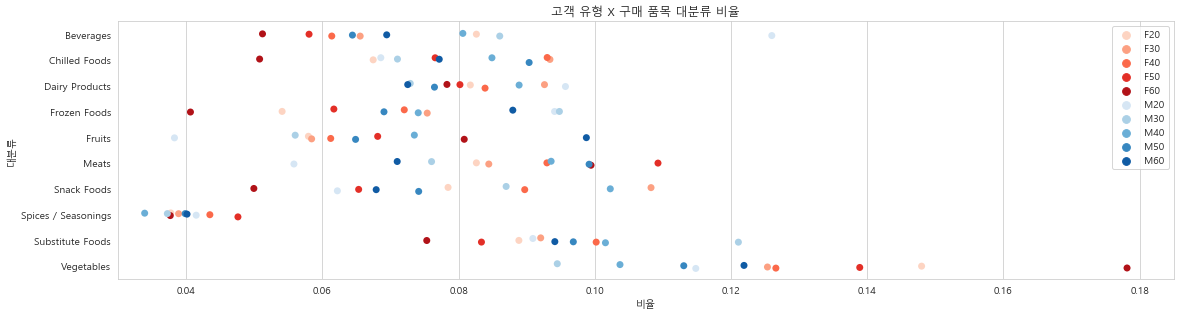

In [63]:
purchase = known[known['action_type']==6]
purchase_trade = purchase.merge(df2trade, how='left', on=['clnt_id','biz_unit','trans_id'])
purchase_trade_item = purchase_trade.merge(df4item, how='left', on='pd_c')

contain_nm1 = purchase_trade_item['clac_nm1'].value_counts().to_frame('count').reset_index()
nm1s = contain_nm1.head(10)['index'].tolist()

clnt_type_nm1 = purchase_trade_item.groupby(['clnt_type','clac_nm1']).size().to_frame('count').reset_index()
type_total = clnt_type_nm1.groupby('clnt_type')['count'].sum().to_frame('total')
clnt_type_nm1 = clnt_type_nm1.merge(type_total, how='left', on='clnt_type')
clnt_type_nm1['ratio'] = clnt_type_nm1['count']/clnt_type_nm1['total']

sample_1 = clnt_type_nm1[clnt_type_nm1['clac_nm1'].isin(nm1s)]

fig, ax = plt.subplots(figsize=(16.5,4.5))
sns.stripplot(data=sample_1, x='ratio', y='clac_nm1', hue='clnt_type', palette=palette, size = 7)

handles, labels = ax.get_legend_handles_labels()
type_labels=['F20','F30','F40','F50','F60','M20','M30','M40','M50','M60']
ax.legend(handles, type_labels, loc='upper right')

plt.title('고객 유형 X 구매 품목 대분류 비율')
plt.xlabel('비율'); plt.ylabel('대분류')
plt.xlim(0.03,0.185)

plt.tight_layout()
plt.savefig('./image/고객 유형 X 구매 품목 대분류 비율.png', dpi=300)
plt.show()

- 성별과 연령대에 따라 구매하는 상품이 다르게 나타남을 관찰할 수 있습니다.

# 키워드 X 구매 품목

키워드와 구매 품목의 종류가 너무 많기 때문에 기록된 수가 상위 10개의 키워드와 구매품목으로만 살펴봅니다.

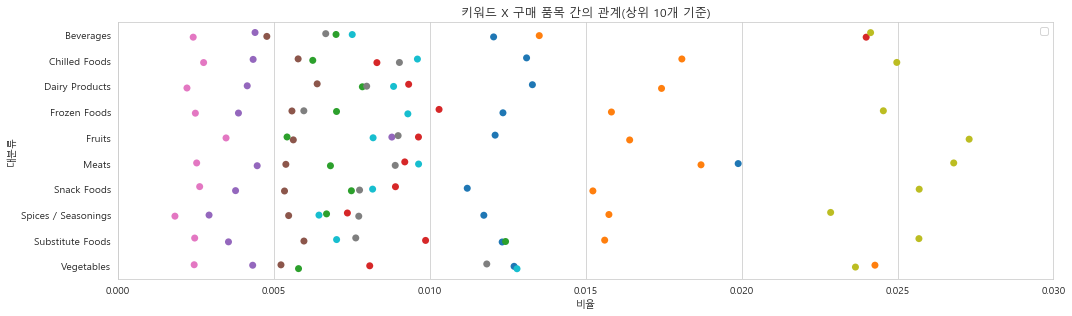

In [66]:
# contain_kwd = df1online['sech_kwd'].value_counts().to_frame('count').reset_index()
# kwds = contain_kwd.head(10)['index'].tolist()

# known_trade = known.merge(df2trade, how='left', on=['clnt_id','biz_unit','trans_id'])
# known_trade_item = known_trade.merge(df4item, how='left', on='pd_c')

# contain_nm1 = known_trade_item['clac_nm1'].value_counts().to_frame('count').reset_index()
# nm1s = contain_nm1.head(10)['index'].tolist()

# sess_kwd = known_trade_item.groupby(['clnt_id','sess_id'])['sech_kwd'].unique().to_frame().reset_index()
# sess_clac_nm1 = known_trade_item.groupby(['clnt_id','sess_id'])['clac_nm1'].unique().to_frame().reset_index()

# kwd_clac_nm1 = sess_kwd.copy()
# kwd_clac_nm1['clac_nm1'] = sess_clac_nm1['clac_nm1']
# kwd_clac_nm1 = kwd_clac_nm1[['sech_kwd','clac_nm1']]

# kwd, nm1 = [[],[]]
# for i in tq(range(len(kwd_clac_nm1))):
#     for j in kwd_clac_nm1.iloc[i,0]:
#         for k in kwd_clac_nm1.iloc[i,1]:
#             kwd.append(j)
#             nm1.append(k)
# output = pd.DataFrame({'kwd':kwd, 'nm1':nm1})
# output = output.dropna().reset_index(drop=True)

# kwd_nm1 = output.groupby(['kwd','nm1']).size().to_frame('count').reset_index()
# nm1_total = kwd_nm1.groupby('nm1')['count'].sum().to_frame('total').reset_index()
# kwd_nm1_total = kwd_nm1.merge(nm1_total, how='left', on='nm1')
# kwd_nm1_total['ratio'] = kwd_nm1_total['count']/kwd_nm1_total['total']

# sample_2 = kwd_nm1_total[(kwd_nm1_total['kwd'].isin(kwds))&(kwd_nm1_total['nm1'].isin(nm1s))]

fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_2, x='ratio', y='nm1', hue='kwd', size = 7)
plt.legend('')
plt.xlim(0,0.03)
plt.title('키워드 X 구매 품목 간의 관계(상위 10개 기준)')
plt.xlabel('비율'); plt.ylabel('대분류')
plt.tight_layout()

plt.savefig('./image/키워드 X 구매 품목 간의 관계.png', dpi=300)
plt.show()

* 고객 검색 키워드와 구매 품목에도 몇몇 구별점이 발견되었습니다.

# 페이지 서핑 속도 X 구매 품목

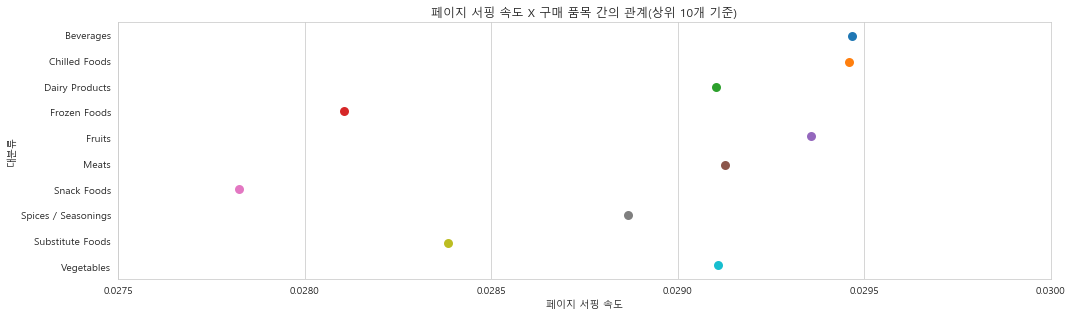

In [67]:
# purchase = known[known['action_type']==6]
# purchase_trade = purchase.merge(df2trade, how='left', on=['clnt_id','biz_unit','trans_id'])
# purchase_trade_item = purchase_trade.merge(df4item, how='left', on='pd_c')

# purchase_trade_item['pv_hr'] = purchase_trade_item['tot_pag_view_ct']/purchase_trade_item['tot_sess_hr_v']

# contain_nm1 = purchase_trade_item['clac_nm1'].value_counts().to_frame('count').reset_index()
# nm1s = contain_nm1.head(10)['index'].tolist()

# pv_hr_nm1 = purchase_trade_item.groupby('clac_nm1')['pv_hr'].median().to_frame('pv_hr').reset_index()
# sample_3 = pv_hr_nm1[pv_hr_nm1['clac_nm1'].isin(nm1s)]

fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_3, x='pv_hr', y='clac_nm1', size = 9)

plt.title('페이지 서핑 속도 X 구매 품목 간의 관계(상위 10개 기준)')
plt.xlim(0.0275,0.03)
plt.xlabel('페이지 서핑 속도'); plt.ylabel('대분류')
plt.tight_layout()

plt.savefig('./image/페이지 서핑 속도 X 구매 품목 간의 관계.png', dpi=300)
plt.show()

* 구매한 상품에 따라 쇼핑 동안 페이지 서핑 속도가 다르게 관찰되었습니다.